In [2]:
import os
from glob import glob
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.path import Path
import pandas as pd

#### Find appropriate parameters for threshold and mask generation

In [3]:
imgPath = r'Z:\GECIScreenData\GECI_Imaging_Data\Non-production'
date = '20230407_S2_NikonEclipse_ionomycin'
sumPath = r'Y:\S2_cell_sensor_expression\Arthur jGCaMP8 ionomycin data'+'\\'+date
savePath = r'Z:\Presentations\Jihong\GENIE production\230411\S2 cell Arthur jGCaMP8 ionomycin data'+'\\'+date
if not os.path.exists(sumPath):
    os.makedirs(sumPath)
if not os.path.exists(savePath):
    os.makedirs(savePath)

In [4]:
W = np.zeros([4194304,2])
for i in range(2048):
    W[i*2048:(i+1)*2048,0] = np.ones(2048)*i
    W[i*2048:(i+1)*2048,1] = np.arange(2048)
W = np.array(W)

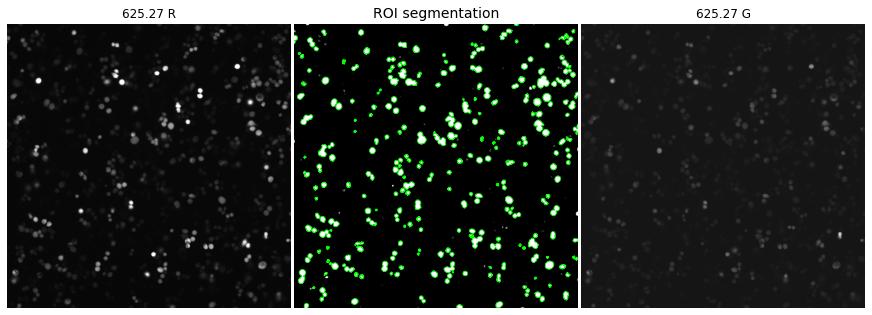

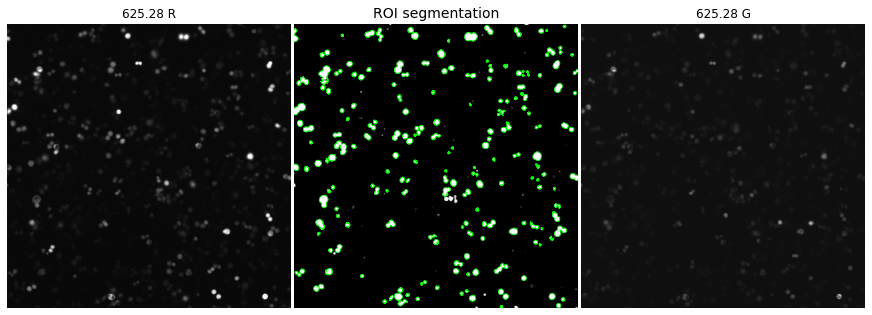

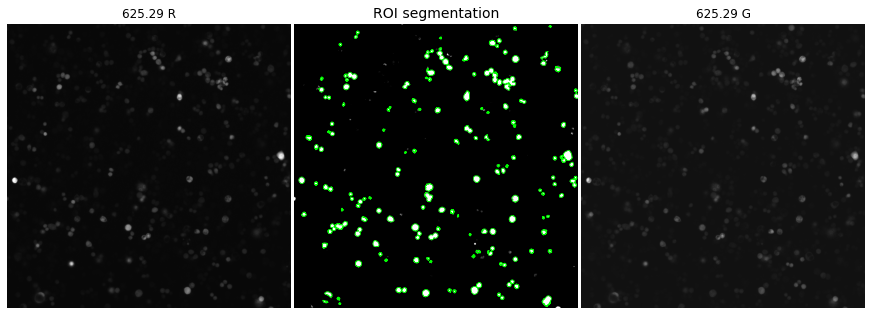

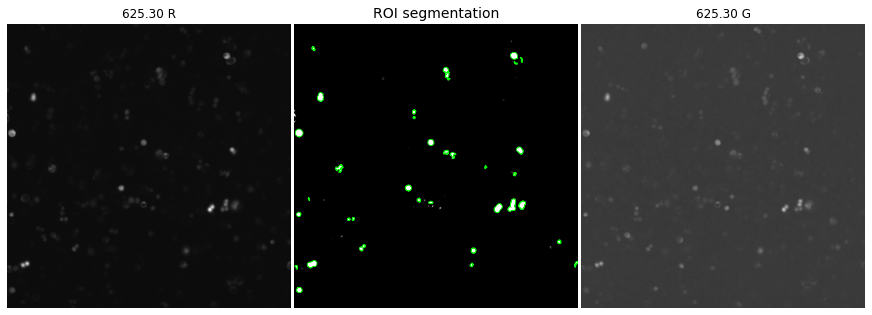

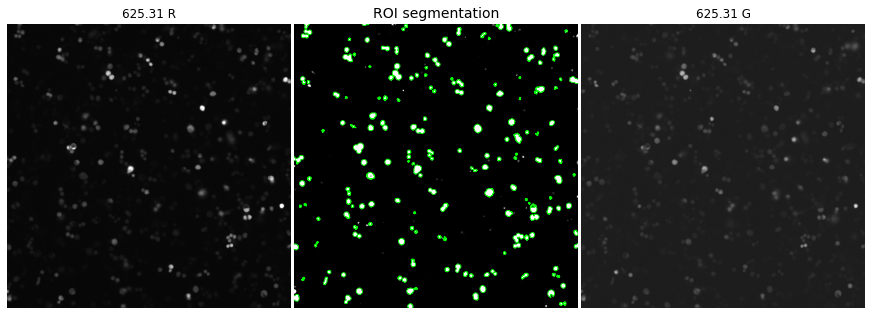

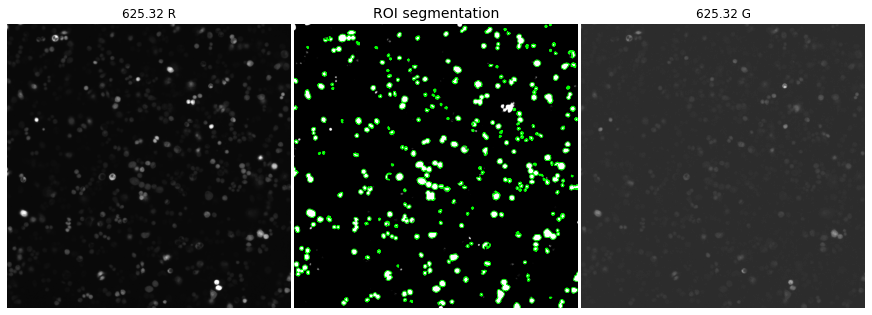

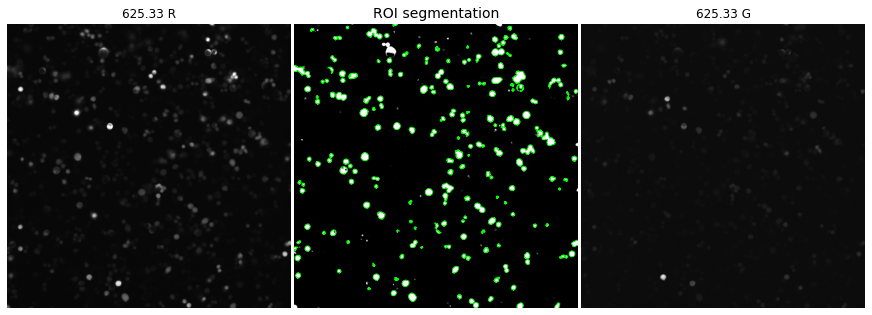

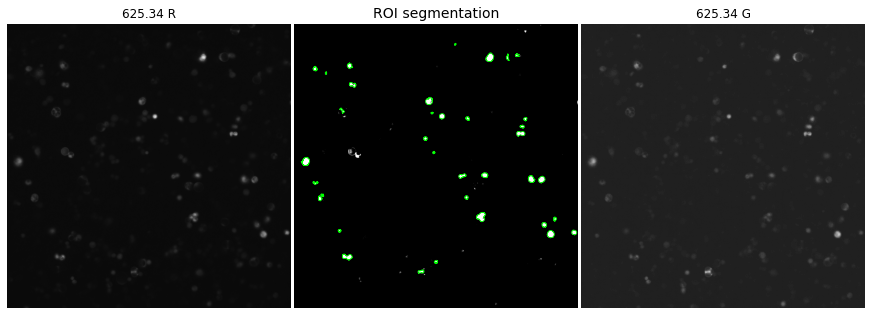

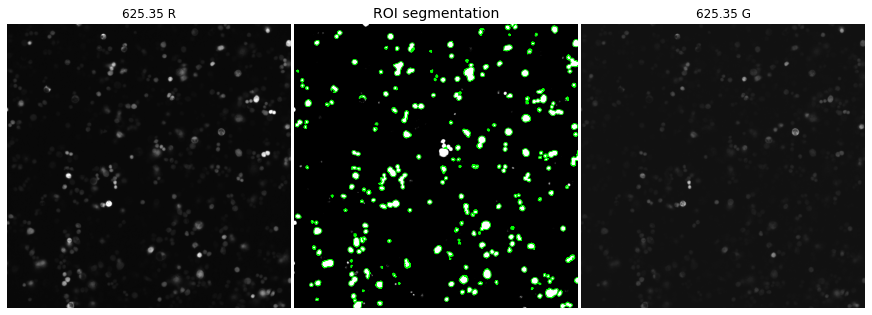

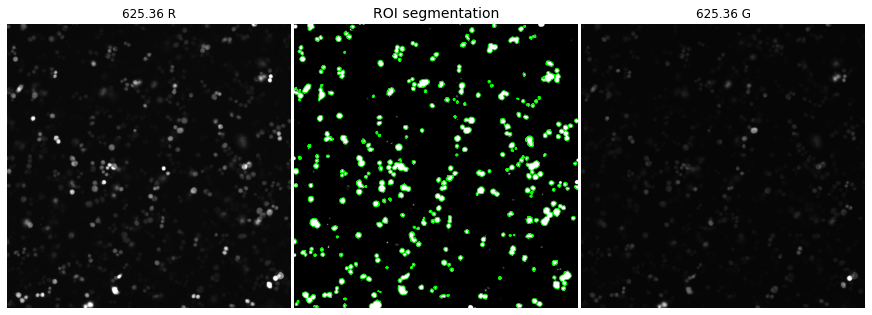

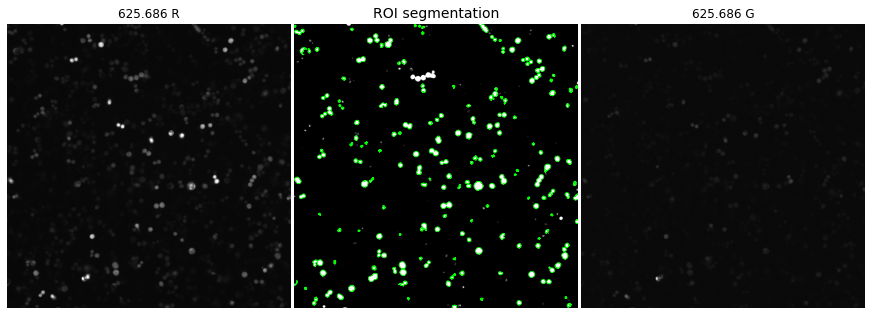

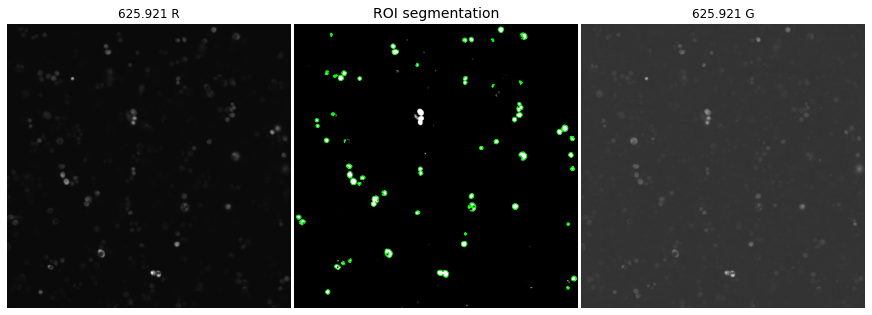

In [5]:
Well = []
Construct = []
Pixels_r = []
Pixels_g = []
Pixels_r_ion = []
Pixels_g_ion = []

thre = 100
# '20x_625dot27_A03_nghkcm1_ionomycin_GFP.tif'
# '20x_625dot686_D05_nghkcm1_ionomycin_GFP_frame6'

# '20x_625dot27_A01_nghkcm1_ionomycin_GFP'

imgFiles = glob(os.path.join(imgPath,date)+'\\*.tif')
RFP_images = [f for f in imgFiles if not 'ionomycin' in os.path.basename(f) and 'RFP' in os.path.basename(f)]
RFP_images.sort()

for img_r in RFP_images:
    imgName = os.path.basename(img_r)
    imgName_split = imgName.split('_')
    
    imgData_r = imread(img_r)
    Fb_r = np.min(imgData_r)
    mask = imgData_r>Fb_r+500
#     mask = imgData_r>Fb_r+200 # 230324 data
    contours = measure.find_contours(mask,fully_connected = 'high')
    
    plt.figure(figsize=[12,5])
    ax1 = plt.subplot(1,3,1)
    ax1.imshow(imgData_r,cmap='gray')
    ax1.set_title(imgName_split[1].replace('dot','.')+' R')
    ax1.axis('off')
    
    rois = []
    ax2 = plt.subplot(1,3,2)
    ax2.imshow(mask,cmap='gray')
    ax2.axis('off')
    ax2.set_title('ROI segmentation',size=14)
    
    img_g = img_r.replace('_RFP','_GFP')
    img_r_ion = img_r.replace('_RFP','_ionomycin_RFP')
    img_g_ion = img_r.replace('_RFP','_ionomycin_GFP')
    
    imgData_g = imread(img_g)
    imgData_r_ion = imread(img_r_ion)
    imgData_g_ion = imread(img_g_ion)
    
    Fb_g = np.min(imgData_g)
    Fb_r_ion = np.min(imgData_r_ion) 
    Fb_g_ion = np.min(imgData_g_ion)
    
    for contour in contours:
        if contour.shape[0]>thre and contour.shape[0]<750:
            Well.append(imgName_split[2])
            Construct.append(imgName_split[1])
           
            ax2.plot(contour[:,1],contour[:,0],color = 'lime',lw=0.75)

            p = Path(contour)
            roi = p.contains_points(W)
            roi = roi.reshape(2048,2048)
            rois.append(roi)
            
            pixels_r = np.sum(roi*imgData_r)/np.sum(roi)
            pixels_g = np.sum(roi*imgData_g)/np.sum(roi)
            pixels_r_ion = np.sum(roi*imgData_r_ion)/np.sum(roi)
            pixels_g_ion = np.sum(roi*imgData_g_ion)/np.sum(roi)

            Pixels_r.append(pixels_r-Fb_r)
            Pixels_g.append(pixels_g-Fb_g)
            Pixels_r_ion.append(pixels_r_ion-Fb_r_ion)
            Pixels_g_ion.append(pixels_g_ion-Fb_g_ion)
            
    ax3 = plt.subplot(1,3,3)
    ax3.imshow(imgData_g,cmap='gray')

    ax3.set_title(imgName_split[1].replace('dot','.')+' G')
    ax3.axis('off')
            
    plt.tight_layout(pad=0.3)
    plt.savefig(savePath+'\\%s.svg' %(imgName_split[1].replace('dot','.')),format='svg')
    plt.show()
    plt.close()

In [6]:
df = pd.DataFrame()

In [7]:
df['Well'] = Well
df['Construct'] = Construct
df['Pixels_r'] = Pixels_r
df['Pixels_g'] = Pixels_g
df['Pixels_r_ion'] = Pixels_r_ion
df['Pixels_g_ion'] = Pixels_g_ion
df['Protocol'] = '12 wells plate; high exposure for green channel imaging'

In [8]:
print(df.shape)
df.to_pickle(sumPath+'\\summary.pkl')

(2031, 7)


### Check all saved data (.pkl)

In [9]:
dataPath = glob(r'Y:\S2_cell_sensor_expression\Arthur jGCaMP8 ionomycin data\2023*')
dataPath

['Y:\\S2_cell_sensor_expression\\Arthur jGCaMP8 ionomycin data\\20230317_S2_NikonEclipse_ionomycin',
 'Y:\\S2_cell_sensor_expression\\Arthur jGCaMP8 ionomycin data\\20230324_S2_NikonEclipse_ionomycin',
 'Y:\\S2_cell_sensor_expression\\Arthur jGCaMP8 ionomycin data\\20230331_NikonEclipse_ionomycin',
 'Y:\\S2_cell_sensor_expression\\Arthur jGCaMP8 ionomycin data\\20230407_S2_NikonEclipse_ionomycin']

In [10]:
# df_3 = pd.read_pickle(dataPath[2]+'\\summary.pkl')
# df_3.columns
# df_1.Well.unique()

In [11]:
# df_3.drop('Protocol',axis=1,inplace=True)

In [ ]:
# df_3['Protocol']='12 wells plate; low exposure for green channel imaging'

In [ ]:
# df_3.to_pickle(dataPath[2]+'\\summary.pkl')

In [22]:
for p in dataPath:
    df_t = pd.read_pickle(p+'\\summary.pkl')
#     df_t['Threshold for ROI segmentation'] = thre_dict[p]
#     df_t.to_pickle(p+'\\summary.pkl')
    print(df_t['Threshold for ROI segmentation'].unique())
    print(df_t.shape)

['Fb+500']
(968, 8)
['Fb+200']
(2484, 8)
['Fb+500']
(2538, 8)


In [14]:
thre_dict = {'Y:\\S2_cell_sensor_expression\\Arthur jGCaMP8 ionomycin data\\20230317_S2_NikonEclipse_ionomycin':'Fb+500',
 'Y:\\S2_cell_sensor_expression\\Arthur jGCaMP8 ionomycin data\\20230324_S2_NikonEclipse_ionomycin':'Fb+200',
 'Y:\\S2_cell_sensor_expression\\Arthur jGCaMP8 ionomycin data\\20230331_NikonEclipse_ionomycin':'Fb+500'}

In [20]:
df_t['Threshold for ROI segmentation'].unique()

array(['Fb+500'], dtype=object)

In [21]:
df_t.columns

Index(['Well', 'Construct', 'Pixels_r', 'Pixels_g', 'Pixels_r_ion',
       'Pixels_g_ion', 'Protocol', 'Threshold for ROI segmentation'],
      dtype='object')